In [2]:
# 标准库
import re
from pathlib import Path
from collections import Counter

# 数据操作与数值计算
import pandas as pd

# 文本预处理与NLP
from textblob import TextBlob
from textblob.sentiments import NaiveBayesAnalyzer, PatternAnalyzer

# 使用gensim建立话题模型
import gensim
from gensim import corpora
from gensim.utils import simple_preprocess

# 可视化
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
from wordcloud import WordCloud, STOPWORDS
import seaborn as sns
import matplotlib.pyplot as plt
from pyecharts.charts import Bar, Line
from pyecharts import options as opts
from pyecharts.globals import ThemeType

# notebook多行输出
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"


# 〇、数据预处理

1. 数据清洗
2. 数据填充
3. 数据格式化

In [3]:

DATASET_PATH = Path("/AIstationzyy/datasets/netflix_reviews.csv")

assert DATASET_PATH.exists(), "Dataset path not right!"

data = pd.read_csv(DATASET_PATH)

"数据总数: " + str(len(data))
data.head()


'数据总数: 112271'

,reviewId,userName,content,score,thumbsUpCount,reviewCreatedVersion,at,appVersion
0,9eea76a3-1b8b-4cb5-a5f3-48cf00f786e4,Faker toz,i rly wanted to watch my favourite show but it...,2,0,NaN,2024-06-05 22:09:02,NaN
1,e81f843a-a8c9-40af-8c0e-f084fde157db,Prince Kpahn,I love this app,5,0,8.85.0 build 9 50502,2024-06-05 22:08:47,8.85.0 build 9 50502
2,be1149b6-730b-4910-810d-04c65800a6a0,Isaiah anis,Great love to enjoy watching latest movies and...,5,0,8.20.0 build 12 40171,2024-06-05 22:07:47,8.20.0 build 12 40171
3,5210b102-ea01-4186-aac2-141647bda83c,Gamalyel Hernandez,Please add all the MY little pony Seasons whic...,4,0,8.117.0 build 3 50695,2024-06-05 22:07:35,8.117.0 build 3 50695
4,1effc685-c8de-412f-8029-a8f0d47b3547,Humle Junior,Nice app,5,0,NaN,2024-06-05 22:06:53,NaN


In [4]:
def preprocess_text(text):
    if isinstance(text, float):
        return ""
    text = text.lower()  # 变成小写字母
    text = re.sub(r'[^\w\s]', '', text)  # 移除标点符号
    text = re.sub(r'\d+', '', text)  # 移除数字(emoji表情也算)
    text = text.strip()  # 移除首尾的空白符
    return text

In [5]:
data['content_c'] = data['content'].apply(preprocess_text)
data.head()

,reviewId,userName,content,score,thumbsUpCount,reviewCreatedVersion,at,appVersion,content_c
0,9eea76a3-1b8b-4cb5-a5f3-48cf00f786e4,Faker toz,i rly wanted to watch my favourite show but it...,2,0,NaN,2024-06-05 22:09:02,NaN,i rly wanted to watch my favourite show but it...
1,e81f843a-a8c9-40af-8c0e-f084fde157db,Prince Kpahn,I love this app,5,0,8.85.0 build 9 50502,2024-06-05 22:08:47,8.85.0 build 9 50502,i love this app
2,be1149b6-730b-4910-810d-04c65800a6a0,Isaiah anis,Great love to enjoy watching latest movies and...,5,0,8.20.0 build 12 40171,2024-06-05 22:07:47,8.20.0 build 12 40171,great love to enjoy watching latest movies and...
3,5210b102-ea01-4186-aac2-141647bda83c,Gamalyel Hernandez,Please add all the MY little pony Seasons whic...,4,0,8.117.0 build 3 50695,2024-06-05 22:07:35,8.117.0 build 3 50695,please add all the my little pony seasons whic...
4,1effc685-c8de-412f-8029-a8f0d47b3547,Humle Junior,Nice app,5,0,NaN,2024-06-05 22:06:53,NaN,nice app


In [6]:
data.isnull()
total_null_values = data.isnull().sum().sum()
print("Total null values in the DataFrame:", total_null_values)

data.fillna('', inplace=True)
data['at'] = pd.to_datetime(data['at'])

data = data[['content_c', 'score', 'reviewId', 'at']]
data.head()

,reviewId,userName,content,score,thumbsUpCount,reviewCreatedVersion,at,appVersion,content_c
0,False,False,False,False,False,True,False,True,False
1,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,True,False,True,False
...,...,...,...,...,...,...,...,...,...
112266,False,False,False,False,False,True,False,True,False
112267,False,False,False,False,False,False,False,False,False
112268,False,False,False,False,False,True,False,True,False
112269,False,False,False,False,False,False,False,False,False


Total null values in the DataFrame: 32565


,content_c,score,reviewId,at
0,i rly wanted to watch my favourite show but it...,2,9eea76a3-1b8b-4cb5-a5f3-48cf00f786e4,2024-06-05 22:09:02
1,i love this app,5,e81f843a-a8c9-40af-8c0e-f084fde157db,2024-06-05 22:08:47
2,great love to enjoy watching latest movies and...,5,be1149b6-730b-4910-810d-04c65800a6a0,2024-06-05 22:07:47
3,please add all the my little pony seasons whic...,4,5210b102-ea01-4186-aac2-141647bda83c,2024-06-05 22:07:35
4,nice app,5,1effc685-c8de-412f-8029-a8f0d47b3547,2024-06-05 22:06:53


# 一、数据分析与可视化

1. 数据的特征分布：电影类型、所属国家类型、评论语言类型
2. 数据可视化：将分布结果通过pyecharts展示出来

In [7]:
# 检查数据范围
date_data = data["at"]
min_date = date_data.min()
max_date = date_data.max()
print(f"最早的 review 数据: {min_date}")
print(f"最晚的 review 数据: {max_date}")

delta_date = max_date - min_date
print(f"时间范围: {delta_date}")


最早的 review 数据: 2018-09-12 07:22:12
最晚的 review 数据: 2024-06-05 22:09:02
时间范围: 2093 days 14:46:50


In [8]:
# 提取月份
data['month'] = data['at'].dt.to_period('M')
# 按月份统计数量
monthly_counts = data['month'].value_counts().sort_index()
# 将结果转换为列表
months = [str(month) for month in monthly_counts.index]
month_counts = monthly_counts.values.tolist()
len(month_counts) # 70
month_counts[1] # [[Period('2018-09', 'M'), 702]]

70

1569

In [9]:
# 数据可视化
month_bar = (
    Bar(init_opts=opts.InitOpts(theme=ThemeType.WESTEROS))
        .add_xaxis(months)
        .add_yaxis('评论数', month_counts)
        .set_global_opts(
            title_opts=opts.TitleOpts(title='按月份统计的评论数量'),
            xaxis_opts=opts.AxisOpts(name="月份"),
            yaxis_opts=opts.AxisOpts(name="数量")
        )
        .set_series_opts(label_opts=opts.LabelOpts(is_show=False))
)

month_line = (
    Line(init_opts=opts.InitOpts(theme=ThemeType.WESTEROS))
        .add_xaxis(months)
        .add_yaxis('评论数', month_counts)
        .set_global_opts(
            title_opts=opts.TitleOpts(title='按月份统计的评论数量'),
            xaxis_opts=opts.AxisOpts(name="月份"),
            yaxis_opts=opts.AxisOpts(name="数量")
        )
        .set_series_opts(label_opts=opts.LabelOpts(is_show=False))
)

month_bar.render_notebook()
    # .overlap(month_line) \
month_line.render_notebook()

In [10]:
# 提取年份
data['year'] = data['at'].dt.year
# 按月份统计数量
yearly_counts = data['year'].value_counts().sort_index()
# 将结果转换为列表
years = [str(year) for year in yearly_counts.index]
year_counts = yearly_counts.values.tolist()
len(year_counts)
year_counts[1]


7

16879

In [11]:

year_bar = (
    Bar(init_opts=opts.InitOpts(theme=ThemeType.WESTEROS))
        .add_xaxis(years)
        .add_yaxis('评论数', year_counts)
        .set_global_opts(
            title_opts=opts.TitleOpts(title='按年份统计的评论数量'),
            xaxis_opts=opts.AxisOpts(name="年份"),
            yaxis_opts=opts.AxisOpts(name="数量")
        )
)

year_bar.render_notebook()

In [12]:
# 按评分统计数量
score_counts = data['score'].value_counts().sort_index()

# 将结果转换为列表
scores = [str(score) for score in score_counts.index]
score_counts = score_counts.values.tolist()

score_bar = (
    Bar(init_opts=opts.InitOpts(theme=ThemeType.WESTEROS))
        .add_xaxis(scores)
        .add_yaxis('各评分记数', score_counts)
        .set_global_opts(
            title_opts=opts.TitleOpts(title='评分计数'),
            xaxis_opts=opts.AxisOpts(name="评分"),
            yaxis_opts=opts.AxisOpts(name="数量")
        )
)

score_bar.render_notebook()

In [13]:
# 按年份分布的评分统计
score_year_counts = data.groupby(['year', 'score']).size().unstack(fill_value=0)

# 将结果转换为列表
year_list = data['year'].unique().tolist()
year_list = [str(year) for year in year_list]
score_list = data["score"].unique().tolist()
score_list.sort()
score_year_dict = {score: score_year_counts[score].tolist() for score in score_list}

In [14]:
year_score_bar = (
    Bar(init_opts=opts.InitOpts())
        .add_xaxis(year_list)
        .set_global_opts(
            title_opts=opts.TitleOpts(title='不同年份的评分分布'),
            xaxis_opts=opts.AxisOpts(name="年份"),
            yaxis_opts=opts.AxisOpts(name="评分")
        )
)
color_list = ["#FF5500", "#FF8800", "#555500", "#88FF00", "#00FF00"]
for score, color in zip(score_list, color_list):
    year_score_bar = year_score_bar.add_yaxis(score, score_year_dict[score], stack=f"stack", color=color)
year_score_bar.render_notebook()

In [15]:
# 按月份分布的评分统计
score_month_counts = data.groupby(['month', 'score']).size().unstack(fill_value=0)

# 将结果转换为列表
month_list = data['month'].unique().tolist()
month_list = [str(month) for month in month_list]
score_list = data["score"].unique().tolist()
score_list.sort()
score_month_dict = {score: score_month_counts[score].tolist() for score in score_list}

In [16]:
color_list = ["#FF5500", "#FF8800", "#555500", "#88FF00", "#00FF00"]

month_score_bar = Bar(init_opts=opts.InitOpts()).add_xaxis(month_list)
for score in score_list:
    month_score_bar = month_score_bar.add_yaxis(score, score_month_dict[score], stack=f"stack")
month_score_bar = (
    month_score_bar.set_global_opts(
            title_opts=opts.TitleOpts(title='不同月份的评分分布'),
            xaxis_opts=opts.AxisOpts(name="月份"),
            yaxis_opts=opts.AxisOpts(name="评分"),
        )
        .set_series_opts(label_opts=opts.LabelOpts(is_show=False))
        .set_colors(color_list)
)
month_score_bar.render_notebook()

# 二、使用决策树进行情感分类

1. 情感分类：好评、差评、无关
2. 情感分布情况

In [38]:
def get_score_sentiment(score):
    if score > 3:
        return 'positive'
    if score == 3:
        return 'neutral'
    if score < 3:
        return 'negative'

data['score_sentiment'] = data['score'].apply(get_score_sentiment)
data[['score', 'score_sentiment']]

,score,score_sentiment
0,2,negative
1,5,positive
2,5,positive
3,4,positive
4,5,positive
...,...,...
112266,5,positive
112267,5,positive
112268,1,negative
112269,1,negative


In [17]:
def get_sentiment(text):
    return TextBlob(text, classifier=NaiveBayesAnalyzer()).sentiment.polarity

In [18]:
data['sentiment'] = data['content_c'].apply(get_sentiment)
data['sentiment_label'] = data['sentiment'].apply(lambda x: 'positive' if x > 0.1 else ('negative' if x < -0.1 else 'neutral'))
data[['content_c', 'score', 'sentiment_label']]

,content_c,score,sentiment_label
0,i rly wanted to watch my favourite show but it...,2,neutral
1,i love this app,5,positive
2,great love to enjoy watching latest movies and...,5,positive
3,please add all the my little pony seasons whic...,4,neutral
4,nice app,5,positive
...,...,...,...
112266,i really like it there are so many movies and ...,5,positive
112267,i love netflix i always enjoy my time using it,5,positive
112268,sound quality is very slow of movies,1,neutral
112269,rate is very expensive bcos we see netflix sun...,1,negative


In [19]:
'positive: ', len(data[data['sentiment_label']=='positive'])
'negative: ', len(data[data['sentiment_label']=='negative'])
'neutral: ', len(data[data['sentiment_label']=='neutral'])

('positive: ', 58111)

('negative: ', 19374)

('neutral: ', 34786)

In [20]:
# 按评分和情感统计数量
sentiment_score_counts = data.groupby(['score', 'sentiment_label']).size().unstack(fill_value=0)

# 将结果转换为列表
score_counts = sentiment_score_counts.index.tolist()
positive_score_counts = sentiment_score_counts['positive'].tolist()
negative_score_counts = sentiment_score_counts['negative'].tolist()
neutral_score_counts = sentiment_score_counts.get('neutral', pd.Series([0] * len(score_counts))).tolist()


In [21]:

sentiment_score_one_bar = (
    Bar(init_opts=opts.InitOpts())
        .add_xaxis(score_counts)
        .add_yaxis('Positive', positive_score_counts, stack='stack1', color='green')
        .add_yaxis('Negative', negative_score_counts, stack='stack1', color='red')
        .add_yaxis('Neutral', neutral_score_counts, stack='stack1', color='gray')
        .set_global_opts(
            title_opts=opts.TitleOpts(title='不同评分的情感分布'),
            xaxis_opts=opts.AxisOpts(name="评分"),
            yaxis_opts=opts.AxisOpts(name="情绪数量")
        )
)
sentiment_score_one_bar.render_notebook()

sentiment_score_two_bar = (
    Bar(init_opts=opts.InitOpts())
        .add_xaxis(score_counts)
        .add_yaxis('Positive', positive_score_counts, stack='stack1', color='green')
        .add_yaxis('Negative', negative_score_counts, stack='stack1', color='red')
        .add_yaxis('Neutral', neutral_score_counts, stack='stack2', color='gray')
        .set_global_opts(
            title_opts=opts.TitleOpts(title='不同评分的情感分布'),
            xaxis_opts=opts.AxisOpts(name="评分"),
            yaxis_opts=opts.AxisOpts(name="情绪数量")
        )
)
sentiment_score_two_bar.render_notebook()

sentiment_score_three_bar = (
    Bar(init_opts=opts.InitOpts())
        .add_xaxis(score_counts)
        .add_yaxis('Positive', positive_score_counts, stack='stack1', color='green')
        .add_yaxis('Negative', negative_score_counts, stack='stack2', color='red')
        .add_yaxis('Neutral', neutral_score_counts, stack='stack3', color='gray')
        .set_global_opts(
            title_opts=opts.TitleOpts(title='不同评分的情感分布'),
            xaxis_opts=opts.AxisOpts(name="评分"),
            yaxis_opts=opts.AxisOpts(name="情绪数量")
        )
)
sentiment_score_three_bar.render_notebook()

In [22]:
# 按月份和情感统计数量
sentiment_month_counts = data.groupby(['month', 'sentiment_label']).size().unstack(fill_value=0)

# 将结果转换为列表
month_counts = sentiment_month_counts.index.tolist()
positive_month_counts = sentiment_month_counts['positive'].tolist()
negative_month_counts = sentiment_month_counts['negative'].tolist()
neutral_month_counts = sentiment_month_counts.get('neutral', pd.Series([0] * len(month_counts))).tolist()


In [23]:

sentiment_month_one_bar = (
    Bar(init_opts=opts.InitOpts())
        .add_xaxis(month_counts)
        .add_yaxis('Positive', positive_month_counts, stack='stack1', color='green')
        .add_yaxis('Negative', negative_month_counts, stack='stack1', color='red')
        .add_yaxis('Neutral', neutral_month_counts, stack='stack1', color='gray')
        .set_global_opts(
            title_opts=opts.TitleOpts(title='不同评分的情感分布'),
            xaxis_opts=opts.AxisOpts(name="评分"),
            yaxis_opts=opts.AxisOpts(name="情绪数量")
        )
)
sentiment_month_one_bar.render_notebook()

In [24]:
# 按评分和情感统计数量
sentiment_year_counts = data.groupby(['year', 'sentiment_label']).size().unstack(fill_value=0)

# 将结果转换为列表
year_counts = sentiment_year_counts.index.tolist()
positive_year_counts = sentiment_year_counts['positive'].tolist()
negative_year_counts = sentiment_year_counts['negative'].tolist()
neutral_year_counts = sentiment_year_counts.get('neutral', pd.Series([0] * len(year_counts))).tolist()

In [25]:

sentiment_year_one_bar = (
    Bar(init_opts=opts.InitOpts(theme=ThemeType.WESTEROS))
        .add_xaxis(year_counts)
        .add_yaxis('Positive', positive_year_counts, stack='stack1')
        .add_yaxis('Negative', negative_year_counts, stack='stack1')
        .add_yaxis('Neutral', neutral_year_counts, stack='stack1')
        .set_global_opts(
            title_opts=opts.TitleOpts(title='不同评分的情感分布'),
            xaxis_opts=opts.AxisOpts(name="评分"),
            yaxis_opts=opts.AxisOpts(name="情绪数量")
        )
)
sentiment_year_one_bar.render_notebook()
sentiment_year_one_bar.render()

'/AIstationzyy/ML/render.html'

4. 词云展示
5. 词云分析：根据词云中的词语可以大致体会用户们的感情来源

In [26]:
# add our list of stopwords
stopwords = set(STOPWORDS)
stopwords.update(['netflix', 'movie', 'show', 'time', 'app', 'series', 'phone']) # creating a custom list based on domain knowledge

negative_reviews = ' '.join(data[data['sentiment_label'] == 'negative']['content_c'])

positive_reviews = ' '.join(data[data['sentiment_label'] == 'positive']['content_c'])

neutral_reviews = ' '.join(data[data['sentiment_label'] == 'neutral']['content_c'])

negative_wordcloud = WordCloud(width=800, height=400, background_color='white', stopwords=stopwords).generate(negative_reviews)
positive_wordcloud = WordCloud(width=800, height=400, background_color='white', stopwords=stopwords).generate(positive_reviews)
neutral_wordcloud = WordCloud(width=800, height=400, background_color='white', stopwords=stopwords).generate(neutral_reviews)

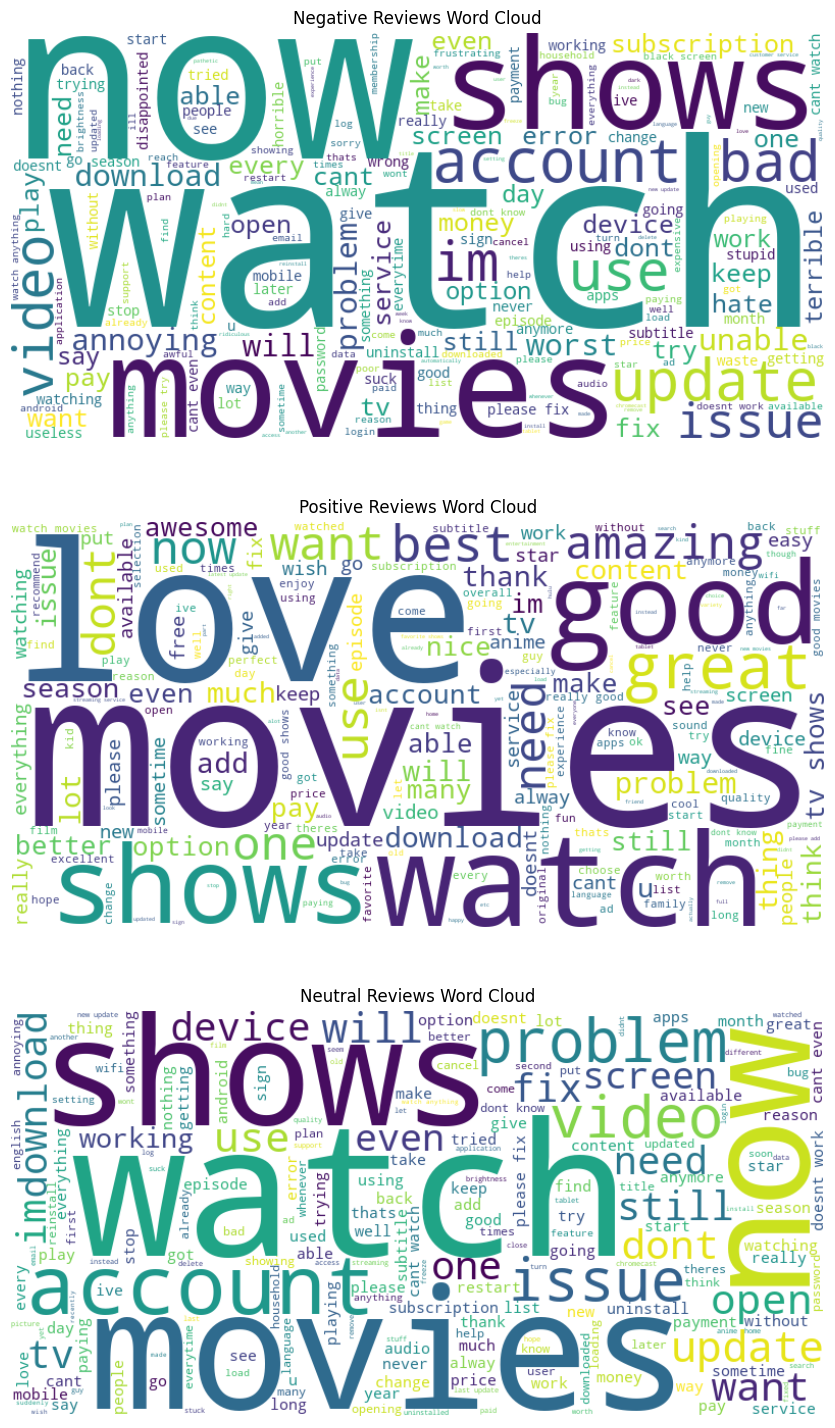

In [27]:
fig, axs = plt.subplots(3, 1, figsize=(36, 18))

_ = axs[0].imshow(negative_wordcloud, interpolation='bilinear')
_ = axs[0].set_title('Negative Reviews Word Cloud')
_ = axs[0].axis('off')

_ = axs[1].imshow(positive_wordcloud, interpolation='bilinear')
_ = axs[1].set_title('Positive Reviews Word Cloud')
_ = axs[1].axis('off')

_ = axs[2].imshow(neutral_wordcloud, interpolation='bilinear')
_ = axs[2].set_title('Neutral Reviews Word Cloud')
_ = axs[2].axis('off')

plt.show()

In [28]:
# preprocess text data in content_c

def preprocess_text_data(text):
    # 文本表计划并移除停止词
    tokens = [token for token in text.lower().split() if token.isalnum()] 
    return tokens

negative_texts = [preprocess_text(text) for text in data[data['sentiment_label']=='negative']['content_c']]
positive_texts = [preprocess_text(text) for text in data[data['sentiment_label']=='positive']['content_c']]
neutral_texts = [preprocess_text(text) for text in data[data['sentiment_label']=='neutral']['content_c']]


In [29]:
"Negative: ", negative_texts[:5]
"Positive: ", positive_texts[:5]
"Neutral: ", neutral_texts[:5]

('Negative: ',
 ['paying for premium but pathetic recommendations restricted number of downloads just after watching a few minutes then you cannot watch the movie again this is ridiculous from netflix',
  'it is full of ugly games that i dont what on my phone i just want my movies and series',
  'over the last months the app became a disaster not reacting when clicking nothing at all items in my lists that i havent added for sure items i have removed i have to remove over and over again because they keep coming back netflix you are horrible',
  'i subscribe because of movies and series how do i hide your game stuff that im not interested in netflix',
  'the thumbnails in the interface are too small for those with failing eyes like myself hence i would sometimes fail to spot the programme i would like to see without the ability to adjust the resolutionsize of this interface i would have no choice but to unsubscribe'])

('Positive: ',
 ['i love this app',
  'great love to enjoy watching latest movies and downloading them',
  'nice app',
  'one word breathtaking i use netflix all the time to watch my anime mha and demon slayer is one of my favourites to watch and netflix just has it all if your an anime fan like me i reccomend this app',
  'best'])

('Neutral: ',
 ['i rly wanted to watch my favourite show but it costs money i added  star',
  'please add all the my little pony seasons which are season  scene theres only',
  'please put home with tip and oh back on here pleaseeee',
  'there are no dragon ball animations',
  'the recent update seems to have fixed the issue thank you now the app works like a dream'])

In [30]:
negative_tokenized_texts = [simple_preprocess(text) for text in negative_texts]
negative_tokenized_texts = [[word for word in doc if word not in stopwords] for doc in negative_tokenized_texts] # 移除停止词

positive_tokenized_texts = [simple_preprocess(text) for text in positive_texts]
positive_tokenized_texts = [[word for word in doc if word not in stopwords] for doc in positive_tokenized_texts] # 移除停止词

neutral_tokenized_texts = [simple_preprocess(text) for text in neutral_texts]
neutral_tokenized_texts = [[word for word in doc if word not in stopwords] for doc in neutral_tokenized_texts] # 移除停止词

# create dict and corpus
negative_dictionary = corpora.Dictionary(negative_tokenized_texts)
negative_corpus = [negative_dictionary.doc2bow(tokens) for tokens in negative_tokenized_texts]

positive_dictionary = corpora.Dictionary(positive_tokenized_texts)
positive_corpus = [positive_dictionary.doc2bow(tokens) for tokens in positive_tokenized_texts]

neutral_dictionary = corpora.Dictionary(neutral_tokenized_texts)
neutral_corpus = [neutral_dictionary.doc2bow(tokens) for tokens in neutral_tokenized_texts]


In [31]:
# 查看结果
negative_tokenized_texts[0][:5]
positive_tokenized_texts[0][:5]
neutral_tokenized_texts[0][:5]


['paying', 'premium', 'pathetic', 'recommendations', 'restricted']

['love']

['rly', 'wanted', 'watch', 'favourite', 'costs']

6. 话题建模：创建LDA模型

In [32]:
# build LDA model
negative_lda_model = gensim.models.LdaMulticore(corpus=negative_corpus, id2word=negative_dictionary, num_topics=5, passes=5, workers=2)
positive_lda_model = gensim.models.LdaMulticore(corpus=positive_corpus, id2word=positive_dictionary, num_topics=5, passes=5, workers=2)
neutral_lda_model = gensim.models.LdaMulticore(corpus=neutral_corpus, id2word=neutral_dictionary, num_topics=5, passes=5, workers=2)

In [33]:
# print topics
negative_topics = negative_lda_model.print_topics(-1)
positive_topics = positive_lda_model.print_topics(-1)
neutral_topics = neutral_lda_model.print_topics(-1)

for idx, topic in negative_topics:
    print(f"Negative topic {idx}: {topic}")
print()

for idx, topic in positive_topics:
    print(f"Positive topic {idx}: {topic}")
print()

for idx, topic in neutral_topics:
    print(f"Neutral topic {idx}: {topic}")


Negative topic 0: 0.015*"bad" + 0.015*"worst" + 0.012*"account" + 0.011*"service" + 0.011*"subscription" + 0.010*"new" + 0.010*"money" + 0.009*"now" + 0.008*"content" + 0.008*"one"
Negative topic 1: 0.024*"screen" + 0.018*"watch" + 0.015*"cant" + 0.013*"fix" + 0.013*"video" + 0.012*"black" + 0.012*"annoying" + 0.011*"update" + 0.010*"every" + 0.010*"play"
Negative topic 2: 0.021*"error" + 0.019*"try" + 0.019*"cant" + 0.019*"please" + 0.018*"unable" + 0.018*"open" + 0.013*"password" + 0.013*"service" + 0.013*"sign" + 0.013*"sorry"
Negative topic 3: 0.035*"movies" + 0.025*"watch" + 0.017*"shows" + 0.013*"im" + 0.012*"dont" + 0.011*"watching" + 0.011*"want" + 0.010*"cant" + 0.009*"annoying" + 0.008*"good"
Negative topic 4: 0.025*"payment" + 0.016*"dont" + 0.015*"please" + 0.012*"cant" + 0.012*"worst" + 0.011*"card" + 0.010*"im" + 0.010*"even" + 0.009*"able" + 0.009*"download"

Positive topic 0: 0.025*"free" + 0.016*"good" + 0.013*"pay" + 0.013*"money" + 0.013*"dont" + 0.011*"better" + 0.0

7. 其他的可视化

In [34]:
# visualize negative topics
negative_vis = gensimvis.prepare(negative_lda_model, negative_corpus, negative_dictionary)
pyLDAvis.display(negative_vis)

In [35]:
# visualize positive topics
positive_vis = gensimvis.prepare(positive_lda_model, positive_corpus, positive_dictionary)
pyLDAvis.display(positive_vis)

In [36]:
# visualize neutral topics
neutral_vis = gensimvis.prepare(neutral_lda_model, neutral_corpus, neutral_dictionary)
pyLDAvis.display(neutral_vis)